<div class="alert alert-block alert-info"> REV4: Hello! Okay, I found the sources in the presentation but actually they must be placed at the end of the notebook. I will not return your work just by this reason, but keep it in mind next time. Also it's better to add the table of context in any your project to easy navigation through your notebook. Anyway, congratulations! You completed the final project and finished the course. Good luck with a new job searching! </div> 

<div class="alert alert-block alert-info"> REV3: Hello, there! You almost completed the project:) The only two things are left. First thing: you ignored the task “Make a list of 5-10 sources (documentation, articles) that you used while working on the project. Provide brief explanations about the questions each source helped you answer.“ I explained the task at the beggining of the channel yandex100_finalproject_telecom-operators_02-3d. Second thing: I can't go though your link to see the presenstation. I don't have access to do it. It seems your link is a private one and not a public. Please, fix it. After these two fixes I will be able to accept your project:)
</div> 

<div class="alert alert-block alert-info"> REV2. Hello, again:) I left several red comments using REV2 keyword. The work is better now but you should make several more fixes. Also, I think, you can add the presentation with the next submit. And don't forget to add a link to dashboard (I checked it already but the link should be in your project) and don't forget to add the block with articles you used. </div> 

<div class="alert alert-block alert-info"> REV: Hello! I checked your project and left several red comments. I think we need several iterations to fix all mistakes because I can find new mistakes after fixing these ones. But don't worry that the deadline is over. We can get necessary amount of iterations. </div> 

# **Identifying Ineffective Operators.** 

## Project description.

In this project I will look at the data from the virtual telephony company and work on finding the least profitable operators with the help of that data. I will also try developping a new function that will give supervisors information on the least effective operators. According to the instructions from the company,  an operator is considered ineffective if the following is true.
### First: many missed calls.
If the operator has a large number of missed incoming calls (internal and external) it is considered a bad sign.

### Second: long waiting time.
If there is a long waiting time for incoming calls, it is also a problem.

### Third: too few outgoing calls.
It is concerning if an operator is supposed to make outgoing calls but there is a relatively small number of them recorded.

In [1]:
import pandas as pd
import numpy as np
import math as mth
from functools import reduce
from scipy import stats as st
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.stats import weightstats as stests

## Preprocessing.
###   First look.
I will open the data and looking at it (shape, describe, info, value_counts etc.).

In [2]:
telecom_dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')
telecom_dataset.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [99]:
telecom_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21945 entries, 5 to 53900
Data columns (total 11 columns):
user_id                21945 non-null int64
date                   21945 non-null datetime64[ns, pytz.FixedOffset(180)]
direction              21945 non-null object
internal               21945 non-null object
operator_id            21945 non-null float64
is_missed_call         21945 non-null bool
calls_count            21945 non-null int64
call_duration          21945 non-null int64
total_call_duration    21945 non-null int64
waiting_time           21945 non-null int64
month                  21945 non-null int64
dtypes: bool(1), datetime64[ns, pytz.FixedOffset(180)](1), float64(1), int64(6), object(2)
memory usage: 1.9+ MB


In [100]:
telecom_dataset.corr()

,user_id,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,month
user_id,1.000000,0.852565,0.026760,0.114695,0.013096,0.032990,0.136560,0.426662
operator_id,0.852565,1.000000,0.024245,0.085958,-0.024901,-0.005096,0.109543,0.518141
is_missed_call,0.026760,0.024245,1.000000,-0.042632,-0.050535,-0.050915,-0.037609,0.011604
calls_count,0.114695,0.085958,-0.042632,1.000000,0.728462,0.787481,0.885132,0.020814
call_duration,0.013096,-0.024901,-0.050535,0.728462,1.000000,0.992954,0.650910,-0.053798
total_call_duration,0.032990,-0.005096,-0.050915,0.787481,0.992954,1.000000,0.736286,-0.043487
waiting_time,0.136560,0.109543,-0.037609,0.885132,0.650910,0.736286,1.000000,0.028608
month,0.426662,0.518141,0.011604,0.020814,-0.053798,-0.043487,0.028608,1.000000


I am interested in correlation between calls count, waiting_time, call duration and total_call_duration, because for others it wouldn't make sense.
We can see there is a very high correlation between columns as follows: 0.7 for calls count and call duration, the same for calls count and total call duration. This is a very significant level of correlation. Correlation between waiting time and calls count is 0.885132, almost 9 which is really close to 100% correlation!
For call duration and total call duration it is almost 100%, but that is obviously to be expected. Correlation for the both call duration columns and waiting time is lower but still significant.  
Now, the columns waiting_time, call duration and total_call_duration are related, so the high correlation is to be expected. But the correlation with calls count column for all three of those is surprisingly high. This is very interesting. 

In [3]:
telecom_clients = pd.read_csv('/datasets/telecom_clients_us.csv')
telecom_clients.head(5)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


###   Checking missing values. 
I will take a look at the percentage of missing values and remove them in case the percentage is low enough.  If there are too many missing values to remove I will replace them with median for numerical colunms (I consider it most effective method since it doesn't get skewed as easily as mean) and something like 'none' for others. 

In [4]:
telecom_dataset.isna().any()

user_id                False
date                   False
direction              False
internal                True
operator_id             True
is_missed_call         False
calls_count            False
call_duration          False
total_call_duration    False
dtype: bool

In [5]:
telecom_clients.isna().any()

user_id        False
tariff_plan    False
date_start     False
dtype: bool

In [6]:
telecom_dataset_missing = telecom_dataset.isna()
telecom_dataset_missing.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False


In [7]:
telecom_dataset_missing.sum() 

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [8]:
telecom_dataset.info()
#As we can see, the percentage of missing values is like this: 117 out of 53902 for internal and 8172 out of 53902 for operator_id
#Now, 8172 is around 15%. It's quite a lot. However, this column will be very important for the analysis, so I would risk removing them.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [9]:
#telecom_dataset = telecom_dataset.drop(telecom_dataset[telecom_dataset['operator_id'] == 'NaN'].index, inplace=True)

In [10]:
telecom_dataset = telecom_dataset[telecom_dataset['operator_id'].notna()]

In [11]:
telecom_dataset = telecom_dataset[telecom_dataset['internal'].notna()]

In [12]:
telecom_dataset_missing2 = telecom_dataset.isna()
telecom_dataset_missing2.sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

### Outliers
I will remove the outliers ( I want to do it in advance because I intend to split the data several times later).

I decided to remove outliers based on IQR, but I believe that z-score would have yielded the same results.

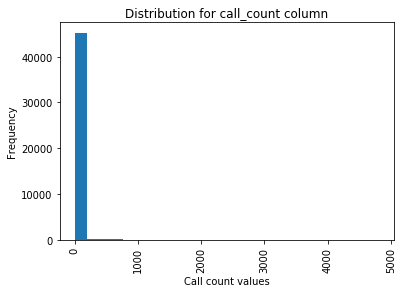

In [13]:
plt.hist(telecom_dataset['calls_count'], bins=25) 
plt.xticks(rotation=90)
plt.xlabel('Call count values')
plt.ylabel('Frequency')
plt.title('Distribution for call_count column')
plt.show()

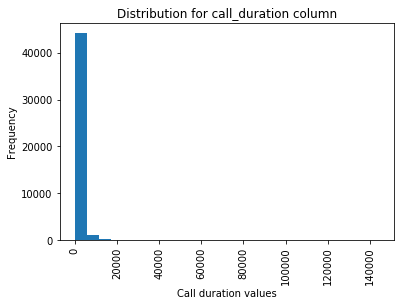

In [14]:
plt.hist(telecom_dataset['call_duration'], bins=25) 
plt.xticks(rotation=90)
plt.xlabel('Call duration values')
plt.ylabel('Frequency')
plt.title('Distribution for call_duration column')
plt.show()

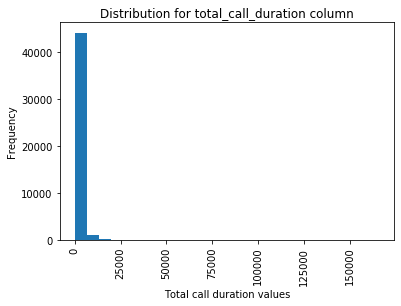

In [15]:
plt.hist(telecom_dataset['total_call_duration'], bins=25) 
plt.xticks(rotation=90)
plt.xlabel('Total call duration values')
plt.ylabel('Frequency')
plt.title('Distribution for total_call_duration column')
plt.show()

We can see on histograms above that there are clear outliers in every column with continuous variables. Thus I will remove them from these columns

In [16]:
q_low = telecom_dataset['total_call_duration'].quantile(0.01)
q_hi  = telecom_dataset['total_call_duration'].quantile(0.99)

telecom_dataset = telecom_dataset[(telecom_dataset['total_call_duration'] < q_hi) & (telecom_dataset['total_call_duration'] > q_low)]

In [17]:
q_low = telecom_dataset['call_duration'].quantile(0.01)
q_hi  = telecom_dataset['call_duration'].quantile(0.99)

telecom_dataset = telecom_dataset[(telecom_dataset['call_duration'] < q_hi) & (telecom_dataset['call_duration'] > q_low)]

In [18]:
q_low = telecom_dataset['calls_count'].quantile(0.01)
q_hi  = telecom_dataset['calls_count'].quantile(0.99)

telecom_dataset = telecom_dataset[(telecom_dataset['calls_count'] < q_hi) & (telecom_dataset['calls_count'] > q_low)]

<div class="alert alert-block alert-danger"> REV: How can you remove outliers using IQR from user_id/operator_id? It can be outliers becasue it's just ids. How can you remove outliers using IQR from direction/internal/is_missed_call? They have only 2 unique values. You can only use IQR to remove ontliers from  calls_count/call_duration/total_call_duration. But to do it without analysing the distribution is also a bad idea. You should work with outliers much more carefully than you did.</div> 

<div class="alert alert-block alert-info"> Hope it is better now. </div> 

### Checking the datatypes.
Looking at the datatypes for all the columns, changing them if necessary. 

In [19]:
telecom_dataset['date'] = pd.to_datetime(telecom_dataset['date'], format="%Y-%m-%d %H:%M")

## Exploratory data analysis. 

### Splitting the dataframe.
First I will divide dataset by missed calls (missed or not) and look at them separately.


In [20]:
telecom_dataset['is_missed_call'].value_counts()

False    21849
True        96
Name: is_missed_call, dtype: int64

In [21]:
telecom_dataset_missed = telecom_dataset.query('is_missed_call == True').reset_index()
telecom_dataset_taken = telecom_dataset.query('is_missed_call == False').reset_index()  #Dividing dataset by missed calls.

In [22]:
telecom_dataset['operator_id'].value_counts()

901884.0    201
901880.0    192
893804.0    181
887276.0    178
889410.0    167
           ... 
954378.0      1
954086.0      1
930264.0      1
888540.0      1
917446.0      1
Name: operator_id, Length: 923, dtype: int64

### Looking at missing calls percentage for each operator.
I will look at the both df's and see which operators have the worst missed/not missed calls ratio. I want to use this identify the least profitable operator. I will group calls by operator in both dfs.

In [23]:
all = telecom_dataset.groupby('operator_id')['is_missed_call'].count()
all.head()

operator_id
879896.0    48
879898.0    91
880020.0     4
880022.0    23
880026.0    88
Name: is_missed_call, dtype: int64

In [24]:
missed = telecom_dataset_missed.groupby('operator_id')['is_missed_call'].count()
missed.head()

operator_id
884408.0    1
885876.0    1
893804.0    1
895574.0    1
900352.0    1
Name: is_missed_call, dtype: int64

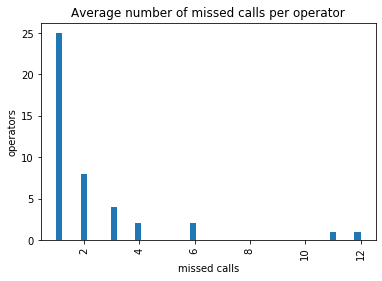

In [25]:
plt.hist(missed, bins=50) 
plt.xticks(rotation=90)
plt.xlabel('missed calls')
plt.ylabel('operators')
plt.title('Average number of missed calls per operator')
plt.show()

We can see that on average the situation with missing calls is not terrible. Only a few operators have more than 6 of them.

In [26]:
taken = telecom_dataset_taken.groupby('operator_id')['is_missed_call'].count()
taken.head()

operator_id
879896.0    48
879898.0    91
880020.0     4
880022.0    23
880026.0    88
Name: is_missed_call, dtype: int64

In [88]:
perc_missed = missed/all*100
perc_missed

operator_id
879896.0   NaN
879898.0   NaN
880020.0   NaN
880022.0   NaN
880026.0   NaN
            ..
972408.0   NaN
972410.0   NaN
972412.0   NaN
972460.0   NaN
973286.0   NaN
Name: is_missed_call, Length: 923, dtype: float64

<div class="alert alert-block alert-danger"> REV: This is wrong. Your function didn't consider indexes and divided wrong rows. Actually, you don't need this function at all. You can just divide one Series into another one: missed / all * 100 </div> 

<div class="alert alert-block alert-info"> I changed it accordingly, hopefully it's correct. </div> 

In [28]:
perc_missed = perc_missed.dropna()
perc_missed.describe()

count     43.000000
mean      10.233816
std       16.976128
min        0.552486
25%        1.948359
50%        5.000000
75%       11.555556
max      100.000000
Name: is_missed_call, dtype: float64

<div class="alert alert-block alert-danger"> REV: You didn't save the result of dropna method. </div> 

<div class="alert alert-block alert-info"> Fixed </div> 

In [29]:
perc_missed.value_counts()

10.000000     2
2.380952      2
16.666667     2
6.000000      2
1.785714      2
2.857143      2
12.500000     1
7.142857      1
4.615385      1
1.219512      1
20.000000     1
13.793103     1
2.061856      1
33.333333     1
0.735294      1
5.000000      1
50.000000     1
100.000000    1
12.000000     1
1.041667      1
14.457831     1
5.882353      1
1.111111      1
0.552486      1
3.846154      1
3.225806      1
1.834862      1
23.404255     1
0.952381      1
7.692308      1
1.694915      1
9.090909      1
3.030303      1
11.111111     1
0.970874      1
2.816901      1
5.555556      1
Name: is_missed_call, dtype: int64

In [30]:
perc_taken = taken/all*100
perc_taken = perc_taken.dropna() #Here we can see the percentage of taken calls by operator id.
perc_taken

operator_id
879896.0    100.0
879898.0    100.0
880020.0    100.0
880022.0    100.0
880026.0    100.0
            ...  
972408.0    100.0
972410.0    100.0
972412.0    100.0
972460.0    100.0
973286.0    100.0
Name: is_missed_call, Length: 922, dtype: float64

In [89]:
perc_taken.value_counts()

100.000000    880
83.333333       2
90.000000       2
94.000000       2
98.214286       2
97.142857       2
97.619048       2
85.542169       1
76.595745       1
99.447514       1
50.000000       1
95.000000       1
97.938144       1
80.000000       1
88.000000       1
88.888889       1
94.117647       1
96.153846       1
99.264706       1
97.183099       1
98.780488       1
92.307692       1
96.969697       1
86.206897       1
99.029126       1
90.909091       1
98.958333       1
99.047619       1
95.384615       1
98.165138       1
94.444444       1
87.500000       1
66.666667       1
98.305085       1
96.774194       1
92.857143       1
98.888889       1
Name: is_missed_call, dtype: int64

<div class="alert alert-block alert-danger"> REV: This is wrong. Your function didn't consider indexes and divided wrong rows. Actually, you don't need this function at all. You can just divide one Series into another one: missed / all * 100 </div> 

<div class="alert alert-block alert-info"> Fixed it again, thank you!. </div> 

### Visualization.
I will plot average waiting time by operator, that is also to look for the least profitable ones. Waiting time is a new column, total call duration minus call duration.

In [31]:
telecom_dataset['total_call_duration'].sort_values(ascending=False).head()

28943    10029
53035     9548
53019     9548
52700     9516
36499     9496
Name: total_call_duration, dtype: int64

In [32]:
telecom_dataset['call_duration'].sort_values(ascending=False).head()

36548    8042
25283    8018
28961    8013
36921    8012
36499    8010
Name: call_duration, dtype: int64

In [33]:
telecom_dataset['waiting_time'] = telecom_dataset['total_call_duration'] - telecom_dataset['call_duration']

In [34]:
telecom_dataset['waiting_time'].sort_values(ascending=False).head()

28943    3495
35004    2217
34878    2112
52775    2007
35147    1994
Name: waiting_time, dtype: int64

In [35]:
telecom_dataset['waiting_time'].value_counts()

26      217
24      202
22      201
16      199
25      195
       ... 
1426      1
1522      1
1538      1
1570      1
1463      1
Name: waiting_time, Length: 1253, dtype: int64

In [36]:
waiting = telecom_dataset.groupby('operator_id')['waiting_time'].mean()

In [37]:
waiting 

operator_id
879896.0     88.916667
879898.0    369.120879
880020.0     19.500000
880022.0     22.695652
880026.0    123.534091
               ...    
972408.0     15.000000
972410.0    228.000000
972412.0    221.500000
972460.0    140.666667
973286.0     88.000000
Name: waiting_time, Length: 923, dtype: float64

<div class="alert alert-block alert-danger"> REV: This code has nothing related to watining_time in fact. You just calculated the number of rows for each operator_id. If you would use another column instead 'waiting_time' you will get absolutely the same result.  </div> 

<div class="alert alert-block alert-info"> I changed it, hopefully correctly. Now I am trying to group the operators by average waiting time.</div> 

<div class="alert alert-block alert-danger"> REV2: operator_id is just an id. You can't calculate mean of all ids cuz it's absolutely meaningless. Id is like a name. It's strange to calculate mean between names, isn't so? But you can group by operator_id and then calculate mean waiting_time for each operator. It makes sense. </div> 


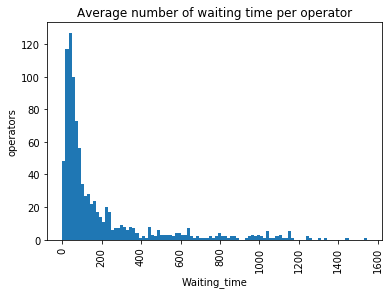

In [38]:
plt.hist(waiting, bins=100) 
plt.xticks(rotation=90)
plt.xlabel('Waiting_time')
plt.ylabel('operators')
plt.title('Average number of waiting time per operator')
plt.show()#plotting waiting_time by operator.

We can see that on average waiting time is not very long excluding a few cases.

<div class="alert alert-block alert-danger"> REV: Wrong table caused wrong graph  </div> 

<div class="alert alert-block alert-info">Hopefully better. </div> 

### Looking at missed calls by month. 
Then I will look at the original df and plot missed calls by date, this may help me determine the most and least profitable months, this is useful information.

In [39]:
telecom_dataset['month'] = telecom_dataset['date'].dt.month
telecom_dataset['month'].value_counts()

11    10183
10     7535
9      3526
8       701
Name: month, dtype: int64

<div class="alert alert-block alert-danger"> REV: Again, how can you count wating_time? It's a continuous feature. By this code you again just calculated the number of rows for each month. The same problem as was above. So the graph and conclusion are wrong.  </div> 

<div class="alert alert-block alert-info"> I decided to remove this alltogether since it doesn't make sense. This code wouldn't take operators into account, only waiting time by date, it is useless. </div> 

<div class="alert alert-block alert-danger"> REV: Again, it's not a waiting_time. These are just a number of rows for each date.  </div> 

### Looking at internal/external calls percentage for each operator.
I will also group calls both missed and not missed dfs by internal/external, see the percentage of missed calls for each operator for internal and external calls.

In [40]:
telecom_dataset_missed_internal = telecom_dataset_missed.query('internal == True').reset_index()

In [41]:
telecom_dataset_missed_external = telecom_dataset_missed.query('internal == False').reset_index()

In [42]:
telecom_dataset_taken_internal = telecom_dataset_taken.query('internal == True').reset_index()

In [43]:
telecom_dataset_taken_external = telecom_dataset_taken.query('internal == False').reset_index()

In [44]:
telecom_dataset_all_internal = telecom_dataset.query('internal == True').reset_index()

In [45]:
telecom_dataset_all_external = telecom_dataset.query('internal == False').reset_index() #The titles are pretty self-explanatory.

In [46]:
all_internal = telecom_dataset_all_internal.groupby('operator_id')['internal'].count()
all_internal

operator_id
879896.0    4
879898.0    1
882478.0    1
884402.0    1
884408.0    1
           ..
966686.0    1
967310.0    1
969268.0    1
969272.0    2
970254.0    1
Name: internal, Length: 245, dtype: int64

In [47]:
all_external = telecom_dataset_all_external.groupby('operator_id')['internal'].count()
all_external

operator_id
879896.0    44
879898.0    90
880020.0     4
880022.0    23
880026.0    88
            ..
972408.0     1
972410.0     2
972412.0     2
972460.0     3
973286.0     1
Name: internal, Length: 887, dtype: int64

In [48]:
missed_internal = telecom_dataset_missed_internal.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
missed_internal #missed internal calls

operator_id  internal
906412.0     True        9
907986.0     True        3
906408.0     True        2
906400.0     True        2
906394.0     True        2
940630.0     True        1
940624.0     True        1
906416.0     True        1
906406.0     True        1
Name: internal, dtype: int64

In [49]:
missed_external = telecom_dataset_missed_external.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
missed_external #missed external calls

operator_id  internal
913942.0     False       12
951508.0     False        6
940588.0     False        6
940622.0     False        4
919206.0     False        3
944216.0     False        3
940630.0     False        3
937860.0     False        2
906412.0     False        2
906392.0     False        2
940624.0     False        2
940652.0     False        2
905104.0     False        2
904344.0     False        2
900354.0     False        1
900352.0     False        1
895574.0     False        1
906410.0     False        1
893804.0     False        1
908960.0     False        1
885876.0     False        1
919166.0     False        1
964666.0     False        1
920706.0     False        1
929424.0     False        1
937368.0     False        1
964510.0     False        1
937898.0     False        1
940616.0     False        1
940658.0     False        1
944222.0     False        1
944226.0     False        1
945046.0     False        1
945052.0     False        1
948286.0     False        

In [50]:
taken_internal = telecom_dataset_taken_internal.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
taken_internal #taken internal calls

operator_id  internal
907182.0     True        50
907986.0     True        47
887278.0     True        43
896008.0     True        43
906406.0     True        43
                         ..
922428.0     True         1
940622.0     True         1
940568.0     True         1
940486.0     True         1
970254.0     True         1
Name: internal, Length: 245, dtype: int64

In [51]:
taken_external = telecom_dataset_taken_external.groupby('operator_id')['internal'].value_counts().sort_values(ascending=False)
taken_external #taken external calls

operator_id  internal
901880.0     False       190
893804.0     False       179
901884.0     False       178
889410.0     False       167
890404.0     False       156
                        ... 
913780.0     False         1
952466.0     False         1
911152.0     False         1
910594.0     False         1
973286.0     False         1
Name: internal, Length: 886, dtype: int64

In [52]:
perc_missed_internal = missed_internal/all_internal*100
perc_missed_internal.sort_values(ascending=False)  #finding the percentage of missed internal calls for each operator.

operator_id  internal
940624.0     True        50.000000
906412.0     True        30.000000
906408.0     True        15.384615
940630.0     True        12.500000
906416.0     True         6.666667
907986.0     True         6.000000
906394.0     True         5.128205
906400.0     True         4.651163
906406.0     True         2.272727
Name: internal, dtype: float64

<div class="alert alert-block alert-danger"> REV: This is wrong. Your function didn't consider indexes and divided wrong rows. Actually, you don't need this function at all. You can just divide one Series into another one: missed / all * 100 </div> 

In [53]:
 #finding the percentage of missed external calls for each operator.

perc_missed_external = missed_external/all_external*100
perc_missed_external.sort_values(ascending=False)

operator_id  internal
904344.0     False       100.000000
906392.0     False        50.000000
919206.0     False        33.333333
937898.0     False        25.000000
951508.0     False        20.000000
940588.0     False        18.181818
937368.0     False        16.666667
913942.0     False        14.457831
940630.0     False        14.285714
940622.0     False        12.903226
906412.0     False        11.764706
884408.0     False        11.111111
945052.0     False        11.111111
964666.0     False        10.000000
919166.0     False         9.090909
964510.0     False         7.692308
945046.0     False         7.142857
940652.0     False         5.714286
944216.0     False         4.615385
940624.0     False         4.166667
895574.0     False         3.846154
937860.0     False         3.333333
948286.0     False         3.125000
906410.0     False         2.857143
920706.0     False         2.857143
940616.0     False         2.631579
954650.0     False         2.439024
905104

<div class="alert alert-block alert-danger"> REV: This is wrong. Your function didn't consider indexes and divided wrong rows. Actually, you don't need this function at all. You can just divide one Series into another one: missed / all * 100 </div> 

In [54]:
perc_missed_internal = perc_missed_internal.dropna()
perc_missed_external = perc_missed_external.dropna() #removing NaN

<div class="alert alert-block alert-danger"> REV: You didn't save the result of dropna method. </div> 

## Formulating and testing statistical hypotheses.

Since we don't have the revenue I would look at which operators and which plans attract more users. Below are all the hypotheses I'd like to test.

###  The average number of users between operators is diferent.
I will see if there is a statistically significant difference and then check if there is a correlation: if the more popular tarif plans are more often chosen by users of the more mopular operators.

###  The average number of missed incoming calls is different between operators.
I will check for statistically significant difference again.

###  The average waiting time is different between operators.
I will also look if there is statistically significant difference between operators.


For all of these I will see if the means of the following columns are significantly different between all operators. I will create the columns if they don't exist yet. I will use st.ttes on random samples and the standard alpha = .05. 

In [55]:
telecom_clients['tariff_plan'].value_counts()

C    395
B    261
A     76
Name: tariff_plan, dtype: int64

During the hypotheses testing I will formulate all the hypotheses like this: 
H0 is that there is a significant difference between proportions for the waiting time/number of missed calls and in/outgoing calls between different tarifs.

In [56]:
telecom_all = pd.merge(telecom_clients, telecom_dataset, how='outer', on ='user_id') 
telecom_all

,user_id,tariff_plan,date_start,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,month
0,166713,A,2019-08-15,2019-08-22 00:00:00+03:00,in,False,891908.0,False,4.0,538.0,568.0,30.0,8.0
1,166713,A,2019-08-15,2019-09-04 00:00:00+03:00,in,False,891908.0,False,2.0,29.0,51.0,22.0,9.0
2,166713,A,2019-08-15,2019-09-19 00:00:00+03:00,in,False,891908.0,False,3.0,321.0,362.0,41.0,9.0
3,166713,A,2019-08-15,2019-10-09 00:00:00+03:00,in,False,891908.0,False,2.0,57.0,78.0,21.0,10.0
4,166713,A,2019-08-15,2019-11-06 00:00:00+03:00,in,False,891908.0,False,4.0,225.0,254.0,29.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22403,166554,B,2019-08-08,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22404,166911,B,2019-08-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22405,167012,B,2019-08-28,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22406,166867,B,2019-08-22,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
telecom_all = telecom_all.dropna()

<div class="alert alert-block alert-danger"> REV: You didn't save the result of dropna method. </div> 

average waiting time , ttest_ind 

NYArr = dataNY['profit'].sample(n=364, random_state=1)
ELSEArr = dataElse['profit'].sample(n=364, random_state=1)
alpha = .05
results = st.ttest_ind(
        NYArr, 
        ELSEArr,
equal_var = False)
print('p-value:', results.pvalue)

In [58]:
telecom_A = telecom_all.query('tariff_plan == "A"').reset_index()
telecom_B = telecom_all.query('tariff_plan == "B"').reset_index()
telecom_C = telecom_all.query('tariff_plan == "C"').reset_index()

In [59]:
telecom_all['tariff_plan'].value_counts()

C    8181
B    7709
A    6055
Name: tariff_plan, dtype: int64

In [60]:
display(telecom_A['waiting_time'].mean())
display(telecom_B['waiting_time'].mean())
display(telecom_C['waiting_time'].mean())

222.93559042113955

165.5346997016474

166.09289817870675

In [61]:
display(telecom_A['waiting_time'].var())
display(telecom_B['waiting_time'].var())
display(telecom_C['waiting_time'].var())

101034.51815002714

49032.01374777242

46020.06642999807

The zero hypothesis(H0) is that the means for the waiting time column between three tarifs are the same. Alternative hypothesis H1 is that the the means are not equal. 

I chose equal_var = False because there is no reason to assume equal population variances.

In [62]:
A_Arr = telecom_A['waiting_time'].sample(n=6055, random_state=1)
B_Arr = telecom_B['waiting_time'].sample(n=6055, random_state=1)
C_Arr = telecom_C['waiting_time'].sample(n=6055, random_state=1)
alpha = .05
results1 = st.ttest_ind(
        A_Arr, 
        B_Arr,
equal_var = False)
display('p-value:', results1.pvalue)

'p-value:'

1.3526371789080575e-31

In [63]:
results2 = st.ttest_ind(
        A_Arr, 
        C_Arr,
equal_var = False)
display('p-value:', results2.pvalue)

'p-value:'

1.1851778144554812e-28

In [64]:
results3 = st.ttest_ind(
        B_Arr, 
        C_Arr,
equal_var = False)
display('p-value:', results3.pvalue)

'p-value:'

0.4196359892367836

In the first two cases we can see that the p-value is lower than alpha value, so we have to reject the zero hypothesis. We have reject the zero hypothesis. That means, we can be sure that the means between these columns are different. However, if we look at the p-value for the B and C columns, we can see that the p-value is higher alpha. This means that for the last two tarifs we can't regect the zero hypothesis. We can't be sure that the means between these columns are different.

<div class="alert alert-block alert-danger"> REV: This is super weird table. How can you use 'waiting_time' as indexes? I don't understand for what purposes you need this table. You wrote what you're going to test 'The average waiting time is different between operators.' But in this case you should group the data by operator_ids. But, as I remember, I lot of operators have a few number of rows, so for them you can't carry any tests. Also, maybe, some operators works only with one tariffs and so you can't compare them with operators from another tariff. You should ckeck it before. Actually, I believe you chose not good hypotheses for test. Maybe it's better to choose something simpler? For instance, average waiting time for different tariffs and so on? There are lot of differnt hypotheses which you can choose. So, please, do it:) If you will choose suggested hypothesis you need to use another statisitcal test, for instance, ttest_ind. Or you can just remove the block with this hypothesis. To complete the project it's okay to test at least one hypothesis. </div> 

<div class="alert alert-block alert-info"> I have tried to change the hypothesis and the testing the way you suggested, hope it's correct. </div> 

In [65]:
pivot2 = telecom_all.pivot_table(index='is_missed_call', columns = 'tariff_plan', values='user_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot2

tariff_plan,is_missed_call,A,B,C
0,False,31,91,147
1,True,8,7,5


In [66]:
pivot2 = pivot2.dropna()
pivot2

tariff_plan,is_missed_call,A,B,C
0,False,31,91,147
1,True,8,7,5


In [67]:
def check_hypothesis2(group1, group2, event, alpha=0.5):
    success1 = pivot2[pivot2.is_missed_call==event][group1].iloc[0]
    success2 = pivot2[pivot2.is_missed_call==event][group2].iloc[0]
    
    trials1 = telecom_all[telecom_all.tariff_plan==group1]['user_id'].nunique()
    trials2 = telecom_all[telecom_all.tariff_plan==group2]['user_id'].nunique()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 +  success2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined + (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    p_value = ( 1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:' , p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there IS a significant difference between proportions for the  two control groups for", event, "between groups", group1, group2)
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the", event, "between groups", group1, group2, "significant")

In [68]:
for i in pivot2.is_missed_call.unique():
    print(i)
    check_hypothesis2('A' ,'B' ,i, alpha=0.05)

False
p_value: 1.0
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the False between groups A B significant
True
p_value: 0.6515481795929139
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the True between groups A B significant


In [69]:
for i in pivot2.is_missed_call.unique():
    print(i)
    check_hypothesis2('A' ,'C' ,i, alpha=0.05)

False
p_value: 1.0
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the False between groups A C significant
True
p_value: 0.4978481883463295
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the True between groups A C significant


In [70]:
for i in pivot2.is_missed_call.unique():
    print(i)
    check_hypothesis2('B' ,'C' ,i, alpha=0.05)

False
p_value: 1.0
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the False between groups B C significant
True
p_value: 0.8686404662729392
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the True between groups B C significant


In [71]:
pivot3 = telecom_all.pivot_table(index='direction', columns = 'tariff_plan', values='user_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot3

tariff_plan,direction,A,B,C
0,in,27,83,136
1,out,26,78,86


In [72]:
pivot3 = pivot3.dropna()
pivot3

tariff_plan,direction,A,B,C
0,in,27,83,136
1,out,26,78,86


In [73]:
def check_hypothesis3(group1, group2, event, alpha=0.5):
    success1 = pivot3[pivot3.direction==event][group1].iloc[0]
    success2 = pivot3[pivot3.direction==event][group2].iloc[0]
    
    trials1 = telecom_all[telecom_all.tariff_plan==group1]['user_id'].nunique()
    trials2 = telecom_all[telecom_all.tariff_plan==group2]['user_id'].nunique()
    
    p1 = success1/trials1

    p2 = success2/trials2

    p_combined = (success1 +  success2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined + (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1)

    p_value = ( 1 - distr.cdf(abs(z_value))) * 2
    
    print('p_value:' , p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: there IS a significant difference between proportions for the  two control groups for", event, "between groups", group1, group2)
    else:
        print("Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the", event, "between groups", group1, group2, "significant")

In [74]:
for i in pivot3.direction.unique():
    print(i)
    check_hypothesis3('A' ,'B' ,i, alpha=0.05)

in
p_value: 0.9655395147153465
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the in between groups A B significant
out
p_value: 0.9841307786044644
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the out between groups A B significant


In [75]:
for i in pivot3.direction.unique():
    print(i)
    check_hypothesis3('A' ,'C' ,i, alpha=0.05)

in
p_value: 0.9549117169323189
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the in between groups A C significant
out
p_value: 0.7518638039224608
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the out between groups A C significant


In [76]:
for i in pivot3.direction.unique():
    print(i)
    check_hypothesis3('B' ,'C' ,i, alpha=0.05)

in
p_value: 0.9891272991757656
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the in between groups B C significant
out
p_value: 0.7440519283706695
Failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the out between groups B C significant


In [77]:
telecom_all.groupby('tariff_plan')['operator_id'].nunique()

tariff_plan
A    278
B    319
C    326
Name: operator_id, dtype: int64

I checked statistical difference between tariffs for the columns call direction and missed call. The H0 is that there is no significant difference between proportions for groups for the given column; H1 is that there is. For all groups we failed to reject the null hypothesis: there is no reason to consider the difference between proportions for the out between groups significant.

<div class="alert alert-block alert-danger"> REV: You didn't test differences in any statistics between different operators. You just tested some statistics between different tariffs. So you can't make such conclusion. </div> 

In [78]:
telecom_dataset_out = telecom_dataset.query('direction == "out"').reset_index()

In [79]:
least_outgoing = telecom_dataset_out.groupby('operator_id')['direction'].count().sort_values(ascending=False)
least_outgoing.tail(10)

operator_id
941736.0    1
924544.0    1
925134.0    1
892534.0    1
892536.0    1
940788.0    1
892798.0    1
892800.0    1
901034.0    1
896386.0    1
Name: direction, dtype: int64

In [92]:
least_outgoing.value_counts()

1      82
2      68
3      40
5      34
4      33
       ..
108     1
47      1
48      1
49      1
109     1
Name: direction, Length: 85, dtype: int64

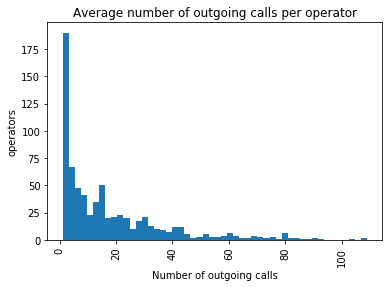

In [80]:
plt.hist(least_outgoing, bins=50) 
plt.xticks(rotation=90)
plt.xlabel('Number of outgoing calls')
plt.ylabel('operators')
plt.title('Average number of outgoing calls per operator')
plt.show()

We can see that the majority of operators actually don't have many outgoing calls.

Below we can see slices of data that would help us analyze all three necessary metrics: missed calls, number of outgoing calls and waiting time.

In [81]:
waiting.value_counts().head(20)

39.0    7
26.0    6
40.0    5
21.0    5
2.0     5
37.0    5
30.0    4
28.0    4
27.0    4
25.0    4
46.0    4
47.0    4
11.0    4
18.0    3
24.0    3
32.5    3
81.0    3
8.0     3
51.0    3
10.0    3
Name: waiting_time, dtype: int64

In [82]:
least_outgoing.value_counts().tail(30)

66     2
64     2
56     2
46     2
84     2
35     2
51     2
91     1
88     1
92     1
78     1
83     1
82     1
87     1
103    1
90     1
63     1
74     1
73     1
72     1
70     1
69     1
59     1
57     1
42     1
108    1
47     1
48     1
49     1
109    1
Name: direction, dtype: int64

In [83]:
missed.value_counts().sort_values(ascending=False)

1     25
2      8
3      4
4      2
6      2
11     1
12     1
Name: is_missed_call, dtype: int64

In [98]:
waiting.value_counts().sort_values(ascending=False)

39.000000     7
26.000000     6
40.000000     5
21.000000     5
2.000000      5
             ..
71.670886     1
43.363636     1
80.333333     1
57.200000     1
193.950000    1
Name: waiting_time, Length: 794, dtype: int64

In [84]:
display(missed.describe())
display(least_outgoing.describe())
display(waiting.describe())

count    43.000000
mean      2.232558
std       2.428376
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      12.000000
Name: is_missed_call, dtype: float64

count    719.000000
mean      17.906815
std       20.115639
min        1.000000
25%        3.000000
50%       10.000000
75%       25.000000
max      109.000000
Name: direction, dtype: float64

count     923.000000
mean      189.063830
std       263.325125
min         1.500000
25%        39.633333
50%        77.043478
75%       210.045455
max      1544.000000
Name: waiting_time, dtype: float64

For missed calls we can see a clear threshold that was also visible on the histogram. I would say that more than 4 missed calls is an outlier. For the others it is way harder. So, I've also looked at mean, median and standard deviation for this data.
After that I stil couldn't decide on a threshold, so I decided to look at 90, 95 and 99 percentiles for the waiting time and 5, 10, 15 for the outgoing calls since we are actually searching for the opposite, the smallest number of calls. 

In [85]:
print(np.percentile(least_outgoing, [1, 5, 10])) 

[1. 1. 1.]


In [86]:
print(np.percentile(waiting, [90, 95, 99])) 

[ 549.62222222  841.2375     1152.988     ]


In [87]:
print(np.percentile(missed, [90, 95, 99])) 

[ 4.    6.   11.58]


After looking at this I decided that it would be reasonable to put the threshold at 90% (549 for waiting time and 1 call for least outgoing calls) since that is what I did with the missed calls and you can also see that threshold on the histogram.

<div class="alert alert-block alert-danger"> REV: The hypotheses shouldn't help you to separate opeartors into effective and ineffective ones. You should analyse number of missed incoming calls, long waiting time for incoming calls and number of outgoing calls and suggest a threshold for each mentioned creteria. After it you should suggest a method of aggregating these 3 creterias into one to decicede which operator is ineffective and which one is not. You can't just write a list of operator_ids and call them ineffective ones without any explained reason. </div> 

<div class="alert alert-block alert-danger"> REV: Doesn't work. There is no variable tail.  </div> 

<div class="alert alert-block alert-danger"> REV2: The situation is better now, but you ignored one of my requests in the previous message: 'After it you should suggest a method of aggregating these 3 creterias into one to decicede which operator is ineffective and which one is not.' You wrote 3 thresholds now, but you didn't write which operators should be considered as ineffective one. Maybe all 3 conditions must be met, or maybe only 2 or even 1 condition is enough. So you should write it explicitly.  </div> 


<div class="alert alert-block alert-info"> Sorry, I forgot to save that cell last time! </div> 

I think we should consider the operators that meet all the conditions ineffective. If they only meet one condition, the situation might not be too bad. If there are few outgoing calls, this probably means that it is not very profitable for the customers to make them, but the operator may conpensate for it in other fields. If there is a long waiting time but there still is a decent number of outgoing calls and not many missed calls it is reasonable to assume that the operator is still making profit despite the long waiting time. As for missed calls, I suspect that the situation with them is highly individual. The number of them may depend on the behavior of specific users. Out of all three metrics this is the one the operator has least control over, in my opinion. 

## General conclusion. 

Above I found the operators that have, in my opinion longest waiting time, most missing calls and least outgoing calls. 
Also, the the hypothesis test lead me to determine that there is a significant statistical difference in waiting time between tariff A and the others. There may be a connection: the operators for this tarif appear to have significantly different waiting time. 

### Introduction 
I think we should consider the operators ineffective if they go over all the afor mentioned threshold for the three important metrics mentioned above, meaning that the values for this metrics fall in 90 percentile for missed calls and waiting time and 10 percentile for outgoing calls. 

### Missing calls 
Overall the situation with missing calls is surprisingly good. The vast majority of operators (880) actually take 100% of calls. On the other hand, there are overall very few outgoing calls. The majority of users only make one or two. Because of this I decided to only remove the operators only if they fail in all three categories. 

###  Waiting time
When it comes to waiting time I find it interesting that 50% of operators have average waiting time below 77, 75% is below 210, 90% below 550, but the maximum mean waiting time is 1500+. This means to me that everything above 90% is probably unprofitable.

### Tariffs
There was an interesting finding related to tariffs. It seems that tariff A is unique; there is a statistical difference between this one an the others for the waiting time column. I would suggest to research it further. A has significantly shorter or longer waiting time and we should fond out which; this way we may also find correlation between tariff and profitability.  

### Correlation
There was also an interesting situation with correlation. The columns waiting_time, call duration and total_call_duration have very high correlation with calls count; this means they must have influence on the number of calls. This is something that varrants further research. In my opinion the correlation is that people who have longer calls also have them more often. This means that the length of the call can help determine the profitability of the operator. Because of this, I was very careful when defining unprofitable operators based on waiting time. I only blacklisted the 10% of operators with longest average waiting time, because the length of it is likely related to the total number of calls, and if there are many calls the operator is not losing money.

### General principle
Overall I was very cautious when deciding the improfitable operators. I explained the situation with waiting time above. When it comes to other metrics, I was also cautious for the following reasons.With missing time I decided not to remove too much because there are very few of them overall. As you can see, 90% of the time there are only 4 of them or less. With such low numbers the difference may be due to the behavior of individual users.

### Outgoing calls
When it comes to outgoing calls the situation is the opposite. There are overal very few of them across all operators. We can see that in 50% cases there are 10 of them or less and one fourth of operators have 3 or less. I decided to only deem the bottom 10% unprofitable with only one outgoing call because otherwise I'd have to remove too much. 

### Operators underperforming in one category
In my opinion the operator underperforming in just one category does not necessairily condemn it. It could still perform well in others. That is especially true for waiting time since the long waiting time may be related to the overall number of calls and in this case it would not be unprofitable. 

### Operators underperforming in two categories
Even two metrics are not enough in my opinion. For example, one operator could have 6 missed calls and long missing time; however, the call count may be high and the missed calls may be related to the behavior of specific users. Similarly, the operator may have few outgoing calls and many missed calls, but many calls overall and low waiting time. While few outgoing calls is concerning and needs to be researched, the operator may still be profitable.

### Final conclusions
These are all the conclusions for now. I would suggest that the operators that go beyond the threshold for all three metrics are most likely to be unprofitable; however, I would also recommend to research call count. I think it influences the profitability as well, we should concidet the overall number of calls. Also, the more calls we have the easier it is to analyse customer behavior. The data from users with a significant number of calls is more reliable in my opinion, the more the better.

<div class="alert alert-block alert-danger"> REV2: The final conclusion should be more detail. You should write about all your important findings which you detect during the project. The idea is that your boss or someone else can read just you final conclusion and understand all your conducted work. The final conclusion should show your project in the most valuable way. You should impress everyone by it. Also, maybe adding some important numbers would be a good idea. </div> 

Tableau link: https://public.tableau.com/views/Dashboard_16193914866470/Dashboard1?:language=en&:display_count=y&:origin=viz_share_link

Presentation: https://docs.google.com/presentation/d/1KcUA32RkxC6J0u1TUYREkaCpENqzc_D2KHdqaEdc9v4/edit?usp=sharing